# Exploratory Data Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob

import noisereduce as nr

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## Local file path

### Only use 6db sample
* Experiment with using 0db or -6dB samples as we do not have baseline background noise

In [2]:

# audio_files = glob('/Users/jaimacabangon/Downloads/slider_0db/*/*/*.wav')
# audio_files_minus_6 = glob('/Users/jaimacabangon/Downloads/slider_-6db/*/*/*.wav')
audio_files = glob('/Users/jaimacabangon/Downloads/slider_6db/*/*/*.wav')
# audio_files_fan_0 = glob('/Users/jaimacabangon/Downloads/fan_0db/*/*/*.wav')
# audio_files_fan_minus_6 = glob('/Users/jaimacabangon/Downloads/fan_-6db/*/*/*.wav')
audio_files_fan_6 = glob('/Users/jaimacabangon/Downloads/fan_6db/*/*/*.wav')
# audio_files_pump_0 = glob('/Users/jaimacabangon/Downloads/pump_0db/*/*/*.wav')
# audio_files_pump_minus_6 = glob('/Users/jaimacabangon/Downloads/pump_-6db/*/*/*.wav')
audio_files_pump_6 = glob('/Users/jaimacabangon/Downloads/pump_6db/*/*/*.wav')
# audio_files_valve_0 = glob('/Users/jaimacabangon/Downloads/valve_0db/*/*/*.wav')
# audio_files_valve_minus_6 = glob('/Users/jaimacabangon/Downloads/valve_-6db/*/*/*.wav')
audio_files_valve_6 = glob('/Users/jaimacabangon/Downloads/valve_6db/*/*/*.wav')


# audio_files.extend(audio_files_6)
# audio_files.extend(audio_files_minus_6)


# audio_files.extend(audio_files_fan_0)
# audio_files.extend(audio_files_fan_minus_6)
audio_files.extend(audio_files_fan_6)

# audio_files.extend(audio_files_pump_0)
# audio_files.extend(audio_files_pump_minus_6)
audio_files.extend(audio_files_pump_6)

# audio_files.extend(audio_files_valve_0)
# audio_files.extend(audio_files_valve_minus_6)
audio_files.extend(audio_files_valve_6)


# Create initial Dataframe
* Split string for data frame creation
* Initial dataframe will include:
    * Machine type (slider, valve, fan, pump)
    * unique machine ID (id_NN)
    * wav file name
    * Sound type (normal vs abnormal)
    * Raw data (raw audio data)

In [3]:
test = audio_files[0]
new = test.split('/')
print(new)

['', 'Users', 'jaimacabangon', 'Downloads', 'slider_6db', 'id_00', 'abnormal', '00000059.wav']


In [4]:
raw_data_list = [] 
sample_rate_list = []
sound_source_list = [] 
binary_classification_list = [] 
wav_file_list = [] 
name_classification_list = []

for audio_file in audio_files:
    split_string = str(audio_file).split('/')
    sound_source = split_string[4]
    name_classification = sound_source.split("_")[0]
    binary_classification = split_string[6]
    wav_file = split_string[7]
    raw_data, sample_rate = librosa.load(audio_file, sr=None)
    sound_source_list.append(sound_source)
    binary_classification_list.append(binary_classification)
    wav_file_list.append(wav_file)
    raw_data_list.append(raw_data)
    sample_rate_list.append(sample_rate)
    name_classification_list.append(name_classification)


    

### 50k samples average time to DF ~5mins

In [5]:
df = pd.DataFrame(columns=["Sound Source","Machine Type", "Classification", ".wav File", "Sample Rate", "Raw Data"])

In [6]:
df["Sound Source"] = sound_source_list
df["Machine Type"] = name_classification_list # label for machine type 
df["Classification"] = binary_classification_list # label for 0 or 1 (normal vs abnormal)
df[".wav File"] = wav_file_list
df["Sample Rate"] = sample_rate_list
df["Raw Data"] = raw_data_list

In [7]:
df

,Sound Source,Machine Type,Classification,.wav File,Sample Rate,Raw Data
0,slider_6db,slider,abnormal,00000059.wav,16000,"[0.0011634827, 0.00012207031, -0.00046539307, ..."
1,slider_6db,slider,abnormal,00000071.wav,16000,"[0.004940033, 0.0047073364, 0.0077323914, -0.0..."
2,slider_6db,slider,abnormal,00000065.wav,16000,"[0.0025291443, 0.002922058, 0.0031700134, 0.00..."
3,slider_6db,slider,abnormal,00000273.wav,16000,"[-0.007286072, -0.0062065125, -0.0077590942, -..."
4,slider_6db,slider,abnormal,00000267.wav,16000,"[-0.0026016235, -0.0023345947, -0.002998352, -..."
...,...,...,...,...,...,...
18014,valve_6db,valve,normal,00000083.wav,16000,"[-0.0015220642, -0.0024032593, -0.0027389526, ..."
18015,valve_6db,valve,normal,00000097.wav,16000,"[-0.0033035278, -0.0030288696, -0.0026435852, ..."
18016,valve_6db,valve,normal,00000068.wav,16000,"[-0.0005912781, -1.9073486e-05, 0.00062179565,..."
18017,valve_6db,valve,normal,00000040.wav,16000,"[-0.00061035156, -0.0008201599, -0.00074768066..."


In [8]:
df['Machine Type'].value_counts()

Machine Type
fan       5550
pump      4205
valve     4170
slider    4094
Name: count, dtype: int64

In [9]:
df['Classification'].value_counts()

Classification
normal      14719
abnormal     3300
Name: count, dtype: int64

### Data taken at consistent sample rate of 16khz
### Abnormal vs normal samples are not 50:50
#### Normal % = 81.7% 
#### Abnormal % =18.3%


### Given Sample rate is consistent, reducing sample rate is not recommended as we could lose audio quality. 

# Baseline Markdown folder determination

### Based on percent difference above of 9.1% (lowest), the difference between the mean of normal vs abnormal in the -6dB samples are relatively small indicating their mean are close to eachother.
### Now given the sorted sound sources above we can see the following: 
- Based on the visualizations we can see the -6dB samples have a pretty consistent .0010/.00098 RMS mean
- The sorted stats above are sorted via rms mean and rms standard deviation 
   - We see that the lowest standard deviation is for the -6dB samples.
        - Indicating that the distribution of the values in the -6dB samples are close to the mean
        - Low standard deviation means that the audio signals are consistent over time, which is typical for background noise (white noise, constant machinery noise etc)
        - This is backed by the visualizations above wether the classification is abnormal or normal the -6dB sample looks to be the least variable over time. 

# Baseline background noise

* RMS Value: -6db sample


|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.009614 | 0.010491 | 9.1%


# Filter background noise from 6dB signal
* NOTE: There is no attenuation happening here, if the audio_data is determined to be noise we zero those samples
  * Attenuation can be done but costly in compute.
     * Attenuation can also overfit our model
     * Example: take an attenuation factor if audio is determined as noise.

In [10]:
import os
import cv2
import librosa
import numpy as np


def generate_mel_spectrogram(audio_vector: np.ndarray, sr: int):
    """Generate mel spectogram image"""

    sgram = librosa.stft(audio_vector)
    # Magnitude + Phase
    sgram_mag, _ = librosa.magphase(sgram)

    # Mel scale 
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)

    # Convert to decibels
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    return mel_sgram



def create_training_data(df: pd.DataFrame):
    """Create training data for mel_sgram"""
    images = []
    labels = []
    for index, row in df.iterrows():
        audio_vector = np.array(row['Raw Data'])  # Convert the raw audio data from the DataFrame row to a numpy array
        sr = row['Sample Rate']  # Get the sample rate
        label = 1 if row['Classification'] == 'abnormal' else 0  # Binary classification: 1 for abnormal, 0 for normal

        mel_sgram = generate_mel_spectrogram(audio_vector, sr)  # Generate Mel spectrogram

        # Normalize the Mel spectrogram for consistent input size
        img_array = cv2.normalize(mel_sgram, None, 0, 1, cv2.NORM_MINMAX)
        img_array = img_array.astype(np.uint8)  # Convert to unsigned 8-bit integer type
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel image (RGB)
        new_img = cv2.resize(img_array, (224, 224))  # Resize to 224x224 pixels

        images.append(new_img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

In [11]:
df.head()

,Sound Source,Machine Type,Classification,.wav File,Sample Rate,Raw Data
0,slider_6db,slider,abnormal,00000059.wav,16000,"[0.0011634827, 0.00012207031, -0.00046539307, ..."
1,slider_6db,slider,abnormal,00000071.wav,16000,"[0.004940033, 0.0047073364, 0.0077323914, -0.0..."
2,slider_6db,slider,abnormal,00000065.wav,16000,"[0.0025291443, 0.002922058, 0.0031700134, 0.00..."
3,slider_6db,slider,abnormal,00000273.wav,16000,"[-0.007286072, -0.0062065125, -0.0077590942, -..."
4,slider_6db,slider,abnormal,00000267.wav,16000,"[-0.0026016235, -0.0023345947, -0.002998352, -..."


fan       5550
pump      4205
valve     4170
slider    4094

In [12]:
slider_df = df[df['Machine Type'] == 'slider']
fan_df = df[df['Machine Type'] == 'fan']
pump_df = df[df['Machine Type'] == 'pump']
valve_df = df[df['Machine Type'] == 'valve']

In [13]:
slider_df['Classification'].value_counts()

Classification
normal      3204
abnormal     890
Name: count, dtype: int64

In [14]:

X, y = create_training_data(slider_df)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

Training data shape: (3275, 224, 224, 3), Training labels shape: (3275,)
Testing data shape: (819, 224, 224, 3), Testing labels shape: (819,)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense, ReLU, Dropout

print("Slider CNN")
# Clear any previous models from memory
tf.keras.backend.clear_session()

# Initialize a sequential model
model_slider = Sequential()

# Adding first conv layer with 32 filters and with kernel size 3
# Increasing the number of filters from 16 to 32 to capture more features from the input image
model_slider.add(Conv2D(filters=32, kernel_size=3, padding="same", input_shape=(224, 224, 3)))
model_slider.add(ReLU())

# Adding second conv layer with 64 filters and with kernel size 3
# Adding a second convolutional layer with more filters to capture even more complex patterns
model_slider.add(Conv2D(filters=64, kernel_size=3, padding='same'))
model_slider.add(ReLU())

# Adding max pooling to reduce the size of output of second conv layer
# Pooling layer to down-sample the feature maps and reduce computational complexity, preventing overfitting
model_slider.add(MaxPooling2D(pool_size=2))

# Adding third conv layer with 128 filters and with kernel size 3
# Adding another convolutional layer to capture higher-level features
model_slider.add(Conv2D(filters=128, kernel_size=3, padding='same'))
model_slider.add(ReLU())

# Adding max pooling to reduce the size of output of third conv layer
model_slider.add(MaxPooling2D(pool_size=2))

# Adding fourth conv layer with 256 filters and with kernel size 3
# Further increasing the number of filters to capture even more detailed patterns
model_slider.add(Conv2D(filters=256, kernel_size=3, padding='same'))
model_slider.add(ReLU())

# Adding max pooling to reduce the size of output of fourth conv layer
model_slider.add(MaxPooling2D(pool_size=2))

# # Adding a dropout layer to prevent overfitting by randomly dropping a fraction of input units during training
# model_1.add(Dropout(0.5))

# Flattening the 3-d output of the conv layers after max pooling to make it ready for creating dense connections with the output layer for predictions
model_slider.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
# Increasing the size of the dense layer to allow the network to learn more complex representations
model_slider.add(Dense(256))
model_slider.add(ReLU())

# # Adding another dropout layer to further reduce overfitting
# model_1.add(Dropout(0.5))

# Adding the output layer with 1 neuron and activation function as sigmoid since this is a binary classification problem
model_slider.add(Dense(1, activation='sigmoid'))

# Compile the model for binary classification
model_slider.compile(
    loss='binary_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.1),  # Reducing the learning rate to improve convergence
    metrics=['accuracy','precision', 'recall']
)

# Print the model summary
model_slider.summary()


Slider CNN


/Users/jaimacabangon/Library/Caches/pypoetry/virtualenvs/keyword-spotting-sAmOcFYZ-py3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,769,153 (197.48 MB)

 Trainable params: 51,769,153 (197.48 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
history_slider = model_slider.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.7442 - loss: 507.4176 - precision: 0.2686 - recall: 0.1076 - val_accuracy: 0.7692 - val_loss: 0.5405 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.7844 - loss: 0.5218 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7692 - val_loss: 0.5410 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.7835 - loss: 0.5242 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7692 - val_loss: 0.5423 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.7925 - loss: 0.5124 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7692 - val_loss: 0.5403 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.7901 - loss: 0.5154 - precision

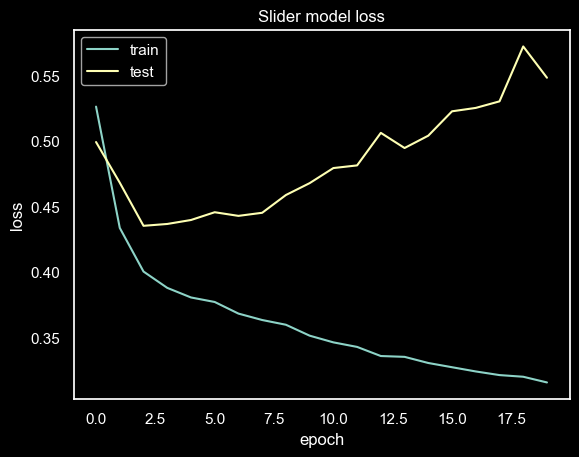

In [51]:
plt.plot(history_slider.history['loss'])
plt.plot(history_slider.history['val_loss'])
plt.title('Slider model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
test_probabilities = model_slider.predict(X_test)

# Convert probabilities to binary class labels
test_predictions = (test_probabilities > 0.5).astype(int).flatten()

# Ensure y_test is in binary format (not one-hot encoded)
# y_test_int = np.argmax(y_test, axis=-1)  # Uncomment if y_test is one-hot encoded

# Classification report
print("FAN",classification_report(y_test, test_predictions))


26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 511ms/step
FAN               precision    recall  f1-score   support

           0       0.77      1.00      0.87       630
           1       0.00      0.00      0.00       189

    accuracy                           0.77       819
   macro avg       0.38      0.50      0.43       819
weighted avg       0.59      0.77      0.67       819



/Users/jaimacabangon/Library/Caches/pypoetry/virtualenvs/keyword-spotting-sAmOcFYZ-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jaimacabangon/Library/Caches/pypoetry/virtualenvs/keyword-spotting-sAmOcFYZ-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jaimacabangon/Library/Caches/pypoetry/virtualenvs/keyword-spotting-sAmOcFYZ-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined

In [18]:
# Calculate accuracy, precision, and recall
TP = sum((test_predictions == 1) & (y_test == 1))
FP = sum((test_predictions == 1) & (y_test == 0))
TN = sum((test_predictions == 0) & (y_test == 0))
FN = sum((test_predictions == 0) & (y_test == 1))

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f"Test evluation metrics for Sliders")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Classification report for detailed metrics
print(classification_report(y_test, test_predictions))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Test evluation metrics for Sliders
Accuracy: 0.7692307692307693
Precision: 0
Recall: 0.0
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       630
           1       0.00      0.00      0.00       189

    accuracy                           0.77       819
   macro avg       0.38      0.50      0.43       819
weighted avg       0.59      0.77      0.67       819

Confusion Matrix:
[[630   0]
 [189   0]]


/Users/jaimacabangon/Library/Caches/pypoetry/virtualenvs/keyword-spotting-sAmOcFYZ-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jaimacabangon/Library/Caches/pypoetry/virtualenvs/keyword-spotting-sAmOcFYZ-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jaimacabangon/Library/Caches/pypoetry/virtualenvs/keyword-spotting-sAmOcFYZ-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense, ReLU, Dropout

print("Fans CNN")
# Clear any previous models from memory
tf.keras.backend.clear_session()

# Initialize a sequential model
model_fans = Sequential()

# Adding first conv layer with 32 filters and with kernel size 3
# Increasing the number of filters from 16 to 32 to capture more features from the input image
model_fans.add(Conv2D(filters=32, kernel_size=3, padding="same", input_shape=(224, 224, 3)))
model_fans.add(ReLU())

# Adding second conv layer with 64 filters and with kernel size 3
# Adding a second convolutional layer with more filters to capture even more complex patterns
model_fans.add(Conv2D(filters=64, kernel_size=3, padding='same'))
model_fans.add(ReLU())

# Adding max pooling to reduce the size of output of second conv layer
# Pooling layer to down-sample the feature maps and reduce computational complexity, preventing overfitting
model_fans.add(MaxPooling2D(pool_size=2))

# Adding third conv layer with 128 filters and with kernel size 3
# Adding another convolutional layer to capture higher-level features
model_fans.add(Conv2D(filters=128, kernel_size=3, padding='same'))
model_fans.add(ReLU())

# Adding max pooling to reduce the size of output of third conv layer
model_fans.add(MaxPooling2D(pool_size=2))

# Adding fourth conv layer with 256 filters and with kernel size 3
# Further increasing the number of filters to capture even more detailed patterns
model_fans.add(Conv2D(filters=256, kernel_size=3, padding='same'))
model_fans.add(ReLU())

# Adding max pooling to reduce the size of output of fourth conv layer
model_fans.add(MaxPooling2D(pool_size=2))

# # Adding a dropout layer to prevent overfitting by randomly dropping a fraction of input units during training
# model_1.add(Dropout(0.5))

# Flattening the 3-d output of the conv layers after max pooling to make it ready for creating dense connections with the output layer for predictions
model_fans.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
# Increasing the size of the dense layer to allow the network to learn more complex representations
model_fans.add(Dense(256))
model_fans.add(ReLU())

# # Adding another dropout layer to further reduce overfitting
# model_1.add(Dropout(0.5))

# Adding the output layer with 1 neuron and activation function as sigmoid since this is a binary classification problem
model_fans.add(Dense(1, activation='sigmoid'))

# Compile the model for binary classification
model_fans.compile(
    loss='binary_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.00001),  # Reducing the learning rate to improve convergence
    metrics=['accuracy','precision', 'recall']
)

# Print the model summary
model_fans.summary()


Fans CNN


/Users/jaimacabangon/Library/Caches/pypoetry/virtualenvs/keyword-spotting-sAmOcFYZ-py3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,769,153 (197.48 MB)

 Trainable params: 51,769,153 (197.48 MB)

 Non-trainable params: 0 (0.00 B)

slider_df = df[df['Machine Type'] == 'slider']
fan_df = df[df['Machine Type'] == 'fan']
pump_df = df[df['Machine Type'] == 'pump']
valve_df = df[df['Machine Type'] == 'valve']

In [20]:
X, y = create_training_data(fan_df)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

Training data shape: (4440, 224, 224, 3), Training labels shape: (4440,)
Testing data shape: (1110, 224, 224, 3), Testing labels shape: (1110,)


In [21]:
# Train the model
history_fan = model_fans.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.7199 - loss: 0.6549 - precision: 0.2917 - recall: 0.0523 - val_accuracy: 0.7405 - val_loss: 0.5720 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.7341 - loss: 0.5748 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7405 - val_loss: 0.5609 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.7263 - loss: 0.5664 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7414 - val_loss: 0.5416 - val_precision: 1.0000 - val_recall: 0.0035
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2404s 17s/step - accuracy: 0.7366 - loss: 0.5337 - precision: 0.6850 - recall: 0.0263 - val_accuracy: 0.7541 - val_loss: 0.5340 - val_precision: 0.7586 - val_recall: 0.0764
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1233s 9s/step - accuracy: 0.7421 - loss: 0.5322 - precision: 0.7408 - recall: 0.07

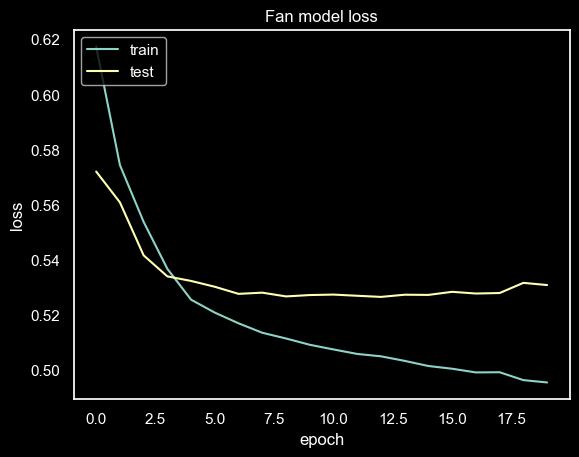

In [35]:
plt.style.use('dark_background')

plt.plot(history_fan.history['loss'])
plt.plot(history_fan.history['val_loss'])
plt.title('Fan model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [23]:
# Generate predictions
test_probabilities = model_fans.predict(X_test)

# Convert probabilities to binary class labels
test_predictions = (test_probabilities > 0.5).astype(int).flatten()

# Ensure y_test is in binary format (not one-hot encoded)
# y_test_int = np.argmax(y_test, axis=-1)  # Uncomment if y_test is one-hot encoded

# Classification report
print("FAN",classification_report(y_test, test_predictions))


# Calculate accuracy, precision, and recall
TP = sum((test_predictions == 1) & (y_test == 1))
FP = sum((test_predictions == 1) & (y_test == 0))
TN = sum((test_predictions == 0) & (y_test == 0))
FN = sum((test_predictions == 0) & (y_test == 1))

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f"Test evluation metrics for Fans")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 622ms/step
FAN               precision    recall  f1-score   support

           0       0.76      0.98      0.86       822
           1       0.69      0.14      0.23       288

    accuracy                           0.76      1110
   macro avg       0.73      0.56      0.54      1110
weighted avg       0.74      0.76      0.70      1110

Test evluation metrics for Fans
Accuracy: 0.7603603603603604
Precision: 0.6896551724137931
Recall: 0.1388888888888889
Confusion Matrix:
[[804  18]
 [248  40]]


slider_df = df[df['Machine Type'] == 'slider']
fan_df = df[df['Machine Type'] == 'fan']
pump_df = df[df['Machine Type'] == 'pump']
valve_df = df[df['Machine Type'] == 'valve']

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense, ReLU, Dropout

print("Valve CNN")
# Clear any previous models from memory
tf.keras.backend.clear_session()

# Initialize a sequential model
model_valve = Sequential()

# Adding first conv layer with 32 filters and with kernel size 3
# Increasing the number of filters from 16 to 32 to capture more features from the input image
model_valve.add(Conv2D(filters=32, kernel_size=3, padding="same", input_shape=(224, 224, 3)))
model_valve.add(ReLU())

# Adding second conv layer with 64 filters and with kernel size 3
# Adding a second convolutional layer with more filters to capture even more complex patterns
model_valve.add(Conv2D(filters=64, kernel_size=3, padding='same'))
model_valve.add(ReLU())

# Adding max pooling to reduce the size of output of second conv layer
# Pooling layer to down-sample the feature maps and reduce computational complexity, preventing overfitting
model_valve.add(MaxPooling2D(pool_size=2))

# Adding third conv layer with 128 filters and with kernel size 3
# Adding another convolutional layer to capture higher-level features
model_valve.add(Conv2D(filters=128, kernel_size=3, padding='same'))
model_valve.add(ReLU())

# Adding max pooling to reduce the size of output of third conv layer
model_valve.add(MaxPooling2D(pool_size=2))

# Adding fourth conv layer with 256 filters and with kernel size 3
# Further increasing the number of filters to capture even more detailed patterns
model_valve.add(Conv2D(filters=256, kernel_size=3, padding='same'))
model_valve.add(ReLU())

# Adding max pooling to reduce the size of output of fourth conv layer
model_valve.add(MaxPooling2D(pool_size=2))

# # Adding a dropout layer to prevent overfitting by randomly dropping a fraction of input units during training
# model_1.add(Dropout(0.5))

# Flattening the 3-d output of the conv layers after max pooling to make it ready for creating dense connections with the output layer for predictions
model_valve.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
# Increasing the size of the dense layer to allow the network to learn more complex representations
model_valve.add(Dense(256))
model_valve.add(ReLU())

# # Adding another dropout layer to further reduce overfitting
# model_1.add(Dropout(0.5))

# Adding the output layer with 1 neuron and activation function as sigmoid since this is a binary classification problem
model_valve.add(Dense(1, activation='sigmoid'))

# Compile the model for binary classification
model_valve.compile(
    loss='binary_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.00001),  # Reducing the learning rate to improve convergence
    metrics=['accuracy','precision', 'recall']
)

# Print the model summary
model_valve.summary()


Valve CNN


/Users/jaimacabangon/Library/Caches/pypoetry/virtualenvs/keyword-spotting-sAmOcFYZ-py3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,769,153 (197.48 MB)

 Trainable params: 51,769,153 (197.48 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
X, y = create_training_data(valve_df)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

Training data shape: (3336, 224, 224, 3), Training labels shape: (3336,)
Testing data shape: (834, 224, 224, 3), Testing labels shape: (834,)


In [26]:
# Train the model
history_valve = model_valve.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1384s 13s/step - accuracy: 0.8792 - loss: 0.6158 - precision: 0.1660 - recall: 0.0216 - val_accuracy: 0.8633 - val_loss: 0.4013 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1142s 11s/step - accuracy: 0.8875 - loss: 0.3516 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8633 - val_loss: 0.4088 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.8918 - loss: 0.3428 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8633 - val_loss: 0.4098 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.8929 - loss: 0.3410 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8633 - val_loss: 0.3978 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 656s 6s/step - accuracy: 0.8816 - loss: 0.3605 - precisi

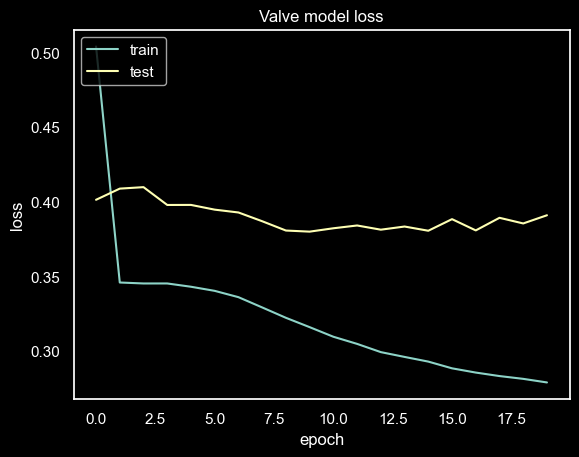

In [36]:

plt.style.use('dark_background')

plt.plot(history_valve.history['loss'])
plt.plot(history_valve.history['val_loss'])
plt.title('Valve model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
# Generate predictions
test_probabilities = model_valve.predict(X_test)

# Convert probabilities to binary class labels
test_predictions = (test_probabilities > 0.5).astype(int).flatten()

# Ensure y_test is in binary format (not one-hot encoded)
# y_test_int = np.argmax(y_test, axis=-1)  # Uncomment if y_test is one-hot encoded

# Classification report
print("FAN",classification_report(y_test, test_predictions))


# Calculate accuracy, precision, and recall
TP = sum((test_predictions == 1) & (y_test == 1))
FP = sum((test_predictions == 1) & (y_test == 0))
TN = sum((test_predictions == 0) & (y_test == 0))
FN = sum((test_predictions == 0) & (y_test == 1))

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f"Test evluation metrics for Valves")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step
FAN               precision    recall  f1-score   support

           0       0.88      0.99      0.93       720
           1       0.64      0.14      0.23       114

    accuracy                           0.87       834
   macro avg       0.76      0.56      0.58       834
weighted avg       0.85      0.87      0.83       834

Test evluation metrics for Valves
Accuracy: 0.8717026378896883
Precision: 0.64
Recall: 0.14035087719298245
Confusion Matrix:
[[711   9]
 [ 98  16]]


slider_df = df[df['Machine Type'] == 'slider']
fan_df = df[df['Machine Type'] == 'fan']
pump_df = df[df['Machine Type'] == 'pump']
valve_df = df[df['Machine Type'] == 'valve']

In [29]:
X, y = create_training_data(pump_df)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

Training data shape: (3364, 224, 224, 3), Training labels shape: (3364,)
Testing data shape: (841, 224, 224, 3), Testing labels shape: (841,)


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense, ReLU, Dropout

print("Pump CNN")
# Clear any previous models from memory
tf.keras.backend.clear_session()

# Initialize a sequential model
model_pump = Sequential()

# Adding first conv layer with 32 filters and with kernel size 3
# Increasing the number of filters from 16 to 32 to capture more features from the input image
model_pump.add(Conv2D(filters=32, kernel_size=3, padding="same", input_shape=(224, 224, 3)))
model_pump.add(ReLU())

# Adding second conv layer with 64 filters and with kernel size 3
# Adding a second convolutional layer with more filters to capture even more complex patterns
model_pump.add(Conv2D(filters=64, kernel_size=3, padding='same'))
model_pump.add(ReLU())

# Adding max pooling to reduce the size of output of second conv layer
# Pooling layer to down-sample the feature maps and reduce computational complexity, preventing overfitting
model_pump.add(MaxPooling2D(pool_size=2))

# Adding third conv layer with 128 filters and with kernel size 3
# Adding another convolutional layer to capture higher-level features
model_pump.add(Conv2D(filters=128, kernel_size=3, padding='same'))
model_pump.add(ReLU())

# Adding max pooling to reduce the size of output of third conv layer
model_pump.add(MaxPooling2D(pool_size=2))

# Adding fourth conv layer with 256 filters and with kernel size 3
# Further increasing the number of filters to capture even more detailed patterns
model_pump.add(Conv2D(filters=256, kernel_size=3, padding='same'))
model_pump.add(ReLU())

# Adding max pooling to reduce the size of output of fourth conv layer
model_pump.add(MaxPooling2D(pool_size=2))

# # Adding a dropout layer to prevent overfitting by randomly dropping a fraction of input units during training
# model_1.add(Dropout(0.5))

# Flattening the 3-d output of the conv layers after max pooling to make it ready for creating dense connections with the output layer for predictions
model_pump.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
# Increasing the size of the dense layer to allow the network to learn more complex representations
model_pump.add(Dense(256))
model_pump.add(ReLU())

# # Adding another dropout layer to further reduce overfitting
# model_1.add(Dropout(0.5))

# Adding the output layer with 1 neuron and activation function as sigmoid since this is a binary classification problem
model_pump.add(Dense(1, activation='sigmoid'))

# Compile the model for binary classification
model_pump.compile(
    loss='binary_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.00001),  # Reducing the learning rate to improve convergence
    metrics=['accuracy','precision', 'recall']
)

# Print the model summary
model_pump.summary()


Pump CNN


/Users/jaimacabangon/Library/Caches/pypoetry/virtualenvs/keyword-spotting-sAmOcFYZ-py3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,769,153 (197.48 MB)

 Trainable params: 51,769,153 (197.48 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the model
history_pump = model_pump.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2498s 21s/step - accuracy: 0.8426 - loss: 0.6234 - precision: 0.1736 - recall: 0.1011 - val_accuracy: 0.8728 - val_loss: 0.3898 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.8905 - loss: 0.3462 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8728 - val_loss: 0.3849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1248s 12s/step - accuracy: 0.8943 - loss: 0.3377 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8728 - val_loss: 0.3822 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1297s 12s/step - accuracy: 0.9000 - loss: 0.3216 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8728 - val_loss: 0.3818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - accuracy: 0.8932 - loss: 0.3326 - preci

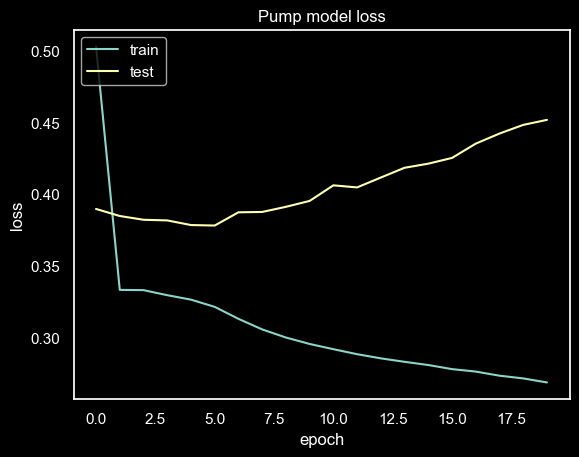

In [37]:
plt.style.use('dark_background')


plt.plot(history_pump.history['loss'])
plt.plot(history_pump.history['val_loss'])
plt.title('Pump model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
# Generate predictions
test_probabilities = model_pump.predict(X_test)

# Convert probabilities to binary class labels
test_predictions = (test_probabilities > 0.5).astype(int).flatten()

# Ensure y_test is in binary format (not one-hot encoded)
# y_test_int = np.argmax(y_test, axis=-1)  # Uncomment if y_test is one-hot encoded

# Classification report
print("FAN",classification_report(y_test, test_predictions))


# Calculate accuracy, precision, and recall
TP = sum((test_predictions == 1) & (y_test == 1))
FP = sum((test_predictions == 1) & (y_test == 0))
TN = sum((test_predictions == 0) & (y_test == 0))
FN = sum((test_predictions == 0) & (y_test == 1))

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f"Test evluation metrics for Pump")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 504ms/step
FAN               precision    recall  f1-score   support

           0       0.88      0.98      0.93       734
           1       0.33      0.07      0.11       107

    accuracy                           0.86       841
   macro avg       0.61      0.52      0.52       841
weighted avg       0.81      0.86      0.82       841

Test evluation metrics for Pump
Accuracy: 0.8644470868014269
Precision: 0.3333333333333333
Recall: 0.06542056074766354
Confusion Matrix:
[[720  14]
 [100   7]]
